In [401]:
import  matplotlib
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical, Beta

import torch
import numpy as np
import pandas as pd
import math
import random

In [2]:
faces_to_values = {str(i): i for i in range(2,11)}
faces_to_values['A'] = 1
for f in ['K', 'Q', 'J']:
    faces_to_values[f] = 10

In [3]:
class Card:
    def __init__(self, face):
        """
        Value: {1, ..., 10, 11, 12, 13} - 11 is J, 12 is Q, 13 is K
        """
        self.face = face
        self.value = faces_to_values[face]
    
    def __repr__(self):
        return self.face

In [6]:
deck = create_deck(2)

In [930]:
# class Blackjack(Model):
    
#     def __init__(self, num_decks):
#         super().__init__(name='Number game')
#         self.num_decks = num_decks
#         self.deck = self._create_decks()
#         self.cards = {}
    
#     def _create_decks(self):
#         deck = []
#         for _ in range(self.num_decks):
#             for face in faces_to_values.keys():
#                 new_card = Card(face)
#                 deck.append(new_card)

#         return deck
    
    
#     def _deal(self, deck):
#         np.random.shuffle(deck)
        
#         # Dealer
#         dealer_card1 = deck.pop()
#         dealer_card2 = deck.pop()
#         self.cards['dealer'] = [dealer_card1, dealer_card2]
        
#         # Player
#         player_card1 = deck.pop()
#         player_card2 = deck.pop()
#         self.cards['player'] = [player_card1, player_card2]
            
    
#     def compute_prob_draw_value(self, deck):
#         counts = np.zeros(11)
#         for card in deck:
#             counts[card.value] += 1
#         return counts

    
    
#     def forward(self):
#         """
#         Generative sampling process
#         """
#         score = 0  # latent variable to infer
        
#         deck_copy = self.deck.copy()
#         self._deal(deck_copy)
        
#         hidden_cards = self.cards['dealer']
        
#         score += hidden_cards[0].value + hidden_cards[1].value
        
#         for i in range(1,7):
#             if score < 16:
#                 likelihood = Categorical(self.compute_prob_draw_value(self.deck))
#                 new_card = deck_copy.pop()
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card.value
#             else:
#                 probs = np.zeros(11)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return score
    
    
# model = Blackjack(num_decks=2)
# model_nn = Blackjack(num_decks=2)

In [947]:
class Deck():
    def __init__(self, num_suites):
        self.value_dict = {i:0 for i in range(11)}
        self.num_suites = num_suites
        
        for _ in range(num_suites):
            for face in faces_to_values.keys():
                new_card = Card(face)
                self.value_dict[new_card.value] += 1
    
    def get_value_probs(self):
        return list(self.value_dict.values())[::]
    
    def get_value_probs_dict(self):
        total_sum = sum(list(self.value_dict.values()))
        return {i:val/float(total_sum) for i,val in self.value_dict.items()}
    
    def __rep__(self):
        return self.value_dict
    
    def draw_card(self):
        value = int(pyprob.sample(Categorical(self.get_value_probs())))
        self.value_dict[value] -= 1
        return value
    
    def copy(self):
        temp = Deck(self.num_suites)
        temp.value_dict = self.value_dict.copy()
        return temp


class Blackjack(Model):
    
    def __init__(self, num_suites):
        super().__init__(name='Number game')
        self.num_suites = num_suites
        self.cards = {}
    
    def _deal(self, deck):
        
        # Dealer
        dealer_card1 = deck.draw_card()
        dealer_card2 = deck.draw_card()
        self.cards['dealer'] = [dealer_card1, dealer_card2]
        
        # Player
        player_card1 = deck.draw_card()
        player_card2 = deck.draw_card()
        self.cards['player'] = [player_card1, player_card2]
        
    def forward_game(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
        
        score = sum(self.cards['dealer'])
        
        for i in range(1,7):
            if score < 16:
                likelihood = Categorical(deck.get_value_probs())
                new_card = deck.draw_card()
                self.cards['dealer'].append(new_card)
                pyprob.observe(likelihood, name='obs{}'.format(i))
                score += new_card
            else:
                probs = np.zeros(11)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, name='obs{}'.format(i))
        
        return deck, self.cards['player'], self.cards['dealer'], score
            
    
    def forward(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
        
        score = sum(self.cards['dealer'])
        
        for i in range(1,7):
            if score < 16:
                likelihood = Categorical(deck.get_value_probs())
                new_card = deck.draw_card()
                pyprob.observe(likelihood, name='obs{}'.format(i))
                score += new_card
            else:
                probs = np.zeros(11)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, name='obs{}'.format(i))
        
        return score
    
    
model = Blackjack(num_suites=4)
model_nn = Blackjack(num_suites=4)

In [948]:
model.forward()

22

# Prior on Dealer Score

Time spent  | Time remain.| Progress             | Trace         | Traces/sec
0d:00:03:51 | 0d:00:00:00 | #################### | 100000/100000 | 431.09       


/Users/theo/anaconda3/envs/csis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


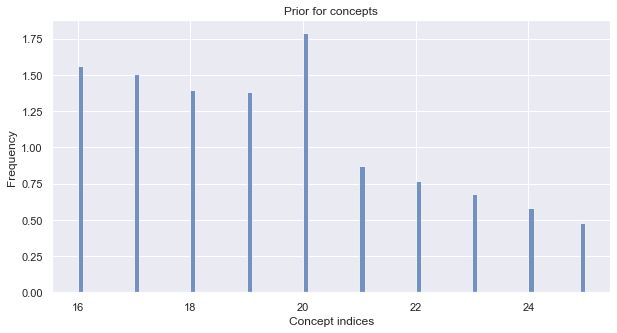

In [962]:
prior = model.prior_results(num_traces=100000)
prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=99)
plt.title('Prior for concepts')
plt.xlabel('Concept indices')
plt.show()

Time spent  | Time remain.| Progress             | Trace         | Traces/sec
0d:00:03:30 | 0d:00:00:00 | #################### | 100000/100000 | 474.50       


/Users/theo/anaconda3/envs/csis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


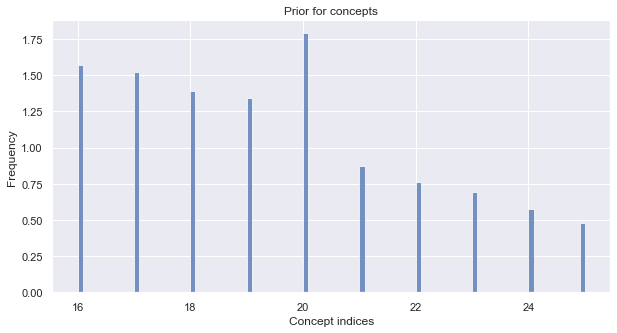

In [963]:
prior = model.prior_results(num_traces=100000)
prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=99)
plt.title('Prior for concepts')
plt.xlabel('Concept indices')
plt.show()

# Dealer Score Posterior - Importance Sampling

In [954]:
observations = {'obs1':5, 'obs2':10, 'obs3':0, 'obs4':0 , 'obs5':0, 'obs6':0}

### Many Samples

Time spent  | Time remain.| Progress             | Trace       | Traces/sec
0d:00:01:36 | 0d:00:00:00 | #################### | 50000/50000 | 516.14       


Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

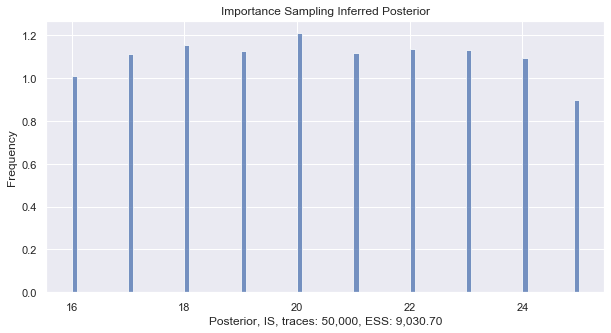

In [956]:
posterior_many = model.posterior_results(
                    num_traces=50000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_many.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')

### Few Samples

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 499.09       


Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

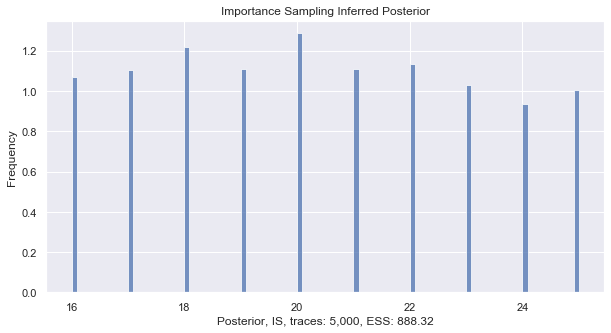

In [955]:
posterior_few = model.posterior_results(
                    num_traces=5000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) 
posterior_few.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')
# plt.savefig('images/importance_sampling_inferred_posterior_200.png')

# Inference Compilation

In [952]:
model_nn.learn_inference_network(num_traces=1000,
                              observe_embeddings={'obs1': {'dim' : 32},
                                                  'obs2': {'dim' : 32},
                                                  'obs3': {'dim' : 32},
                                                  'obs4': {'dim' : 32},
                                                  'obs5': {'dim' : 32},
                                                  'obs6': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Continuing to train existing inference network...
Total number of parameters: 3,058,551
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
0d:00:01:02 | 1    | 12,032    | +1.20e+01 | +8.66e+00 | +1.07e+01 | 0d:00:00:07 | +1.00e-03 | 208.7 
Stop condition reached. num_traces: 1000
0d:00:01:03 | 1    | 12,096    | +1.20e+01 | +8.66e+00 | +9.81e+00 | 0d:00:00:07 | +1.00e-03 | 191.6 


In [617]:
posterior_nn = model_nn.posterior_results(num_traces=1000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_nn.plot_histogram(show=False, bins=99, alpha=0.75, label='inferred posterior')
plt.title('Inference Network Importance Sampling Inferred Posterior')

Time spent  | Time remain.| Progress             | Trace     | Traces/sec


RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

In [615]:
combined = posterior_2000.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis, key=lambda x: x[1], reverse=True)

[(22, 0.11799401758414134),
 (20, 0.10910054738622853),
 (17, 0.10540218620806194),
 (18, 0.10262842575734707),
 (16, 0.10223220303156243),
 (19, 0.09809358692543273),
 (23, 0.09598027415694763),
 (24, 0.09237005439960745),
 (25, 0.09148949296478279),
 (21, 0.08470921158588812)]

# Simulating Games

## My strategy

In [771]:
def calc_EV(x, deck, dealerDistribution):
    
    EV_table = {}
    
    def calc_EV_helper(x, deck, dealerDistribution):

        if x in EV_table:
            return EV_table[x]
                
        if x > 21:
            EV_table[x] = ((1 - dealerDistribution.p_bust) * (-1), False)
            return EV_table[x]
        
        elif x <= 21:
            
            EV_stay_dealer_bust = dealerDistribution.p_bust * (1)
            EV_stay_dealer_no_bust = (1 - dealerDistribution.p_bust) * (dealerDistribution.p_less_than(x) * (1) + dealerDistribution.p_greater_than(x) * (-1))
            EV_stay = EV_stay_dealer_bust + EV_stay_dealer_no_bust
            
            EV_hit = 0
            for val,prob in deck.get_value_probs_dict().items():
                if prob > 0:
                    deck_copy = deck.copy()
                    deck_copy.value_dict[val] -= 1
                    EV_hit += prob * calc_EV_helper(x + val, deck_copy, dealerDistribution)[0]

        if EV_hit > EV_stay:
            EV_table[x] = (EV_hit, True)
        else:
            EV_table[x] = (EV_stay, False)
        return EV_table[x]
    
    return calc_EV_helper(x, deck, dealerDistribution)
            
# deck = Deck(4)
# for i in range(1,30):
    
#     EV, play = calc_EV(i, deck, dist)
#     print(i, EV, play)

## Infer Dealer Distribution

In [911]:
class DealerDistribution:
    
    def __init__(self, posterior):
        self.posterior = posterior
        self.probs = {}
        self.p_bust = 0
        
        combined = posterior.combine_duplicates()
        posterior_probs = {combined[i]:np.exp(combined._get_log_weight(i).item()) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001}
        for key, prob in posterior_probs.items():
            if key <= 21:
                self.probs[key] = prob
            else:
                self.p_bust += prob

    def p_less_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key < x:
                p += prob
        return p
    
    def p_greater_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key > x:
                p += prob
        return p
    
    def plot(self):
        self.posterior.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
        plt.title('Importance Sampling Inferred Posterior')
        return

# dist = DealerDistribution(hypothesis)
# print(dist.p_bust)
# dist.probs

In [912]:
def infer_dealer_score(dealer_cards, num_traces, use_nn=False):

    observations = {}
    for i in range(2,7):
        if i < len(dealer_cards):
            observations['obs{}'.format(i-1)] = dealer_cards[i]
        else:
            observations['obs{}'.format(i)] = 0
    print(observations)

    if use_nn:
        pass
    else:
        posterior = model.posterior_results(
                            num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                            observe=observations) 
        
    dealer_posterior = DealerDistribution(posterior)
    return dealer_posterior

## Simulate n Games

In [978]:
dealer_dist_prior = DealerDistribution(prior)
dealer_dist_prior

In [981]:
dealer_dist_prior.probs

{20: 0.16263664178525794,
 16: 0.14271870998791436,
 21: 0.07940962660713588,
 18: 0.1262848659626043,
 19: 0.12207704147267709,
 17: 0.1382492470107526}

In [988]:
def play(deck, player_cards, dealer_cards, dealer_dist):
    score = sum(player_cards)
    EV, should_hit = calc_EV(score, deck, dealer_dist)
    while should_hit:
        new_card = deck.draw_card()
#         print(new_card)
        score += new_card
        EV, should_hit = calc_EV(score, deck, dealer_dist)
        
#     print("Final Score: {}".format(score))
    return score

In [ ]:
day_wealth = []
for day in range(1000):
    
    print('Day {}'.format(day))
    wealth = 0
    n = 100

    for i in range(n):

        deck, player_cards, dealer_cards, score = model.forward_game()
    #     print(player_cards, dealer_cards)
    #     inferred_dealer_dist = infer_dealer_score(dealer_cards, 5000)
        player_score = play(deck, player_cards, dealer_cards, dealer_dist_prior)
        dealer_score = sum(dealer_cards)
        wealth += payout(player_score, dealer_score)

    day_wealth.append(wealth)

Day 0
Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Day 8
Day 9
Day 10
Day 11
Day 12
Day 13
Day 14
Day 15
Day 16
Day 17
Day 18
Day 19
Day 20
Day 21
Day 22
Day 23
Day 24
Day 25
Day 26
Day 27
Day 28
Day 29
Day 30
Day 31
Day 32
Day 33
Day 34
Day 35
Day 36
Day 37
Day 38
Day 39
Day 40
Day 41
Day 42
Day 43
Day 44
Day 45
Day 46
Day 47
Day 48
Day 49
Day 50
Day 51
Day 52
Day 53
Day 54
Day 55
Day 56
Day 57
Day 58
Day 59
Day 60
Day 61
Day 62
Day 63
Day 64
Day 65
Day 66
Day 67
Day 68
Day 69
Day 70
Day 71
Day 72
Day 73
Day 74
Day 75
Day 76
Day 77
Day 78
Day 79
Day 80
Day 81
Day 82
Day 83
Day 84
Day 85
Day 86
Day 87
Day 88
Day 89
Day 90
Day 91
Day 92
Day 93
Day 94
Day 95
Day 96
Day 97
Day 98
Day 99
Day 100
Day 101
Day 102
Day 103


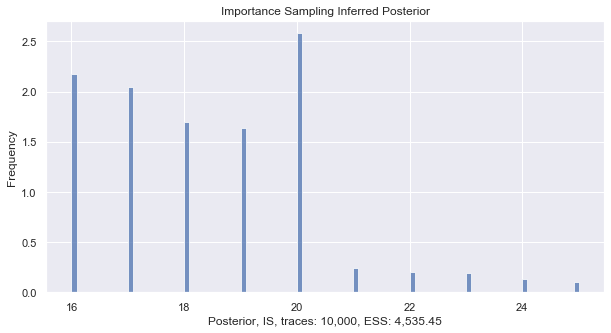

In [915]:
inferred_dealer_dist.plot()

In [996]:
def payout(player_score, dealer_score):
    if player_score > 21:
        if dealer_score > 21:
            return 0
        else:
            return -1
    else:
        if dealer_score > 21 or (player_score > dealer_score):
            return 1
        elif player_score < dealer_score:
            return -1
        elif player_score == dealer_score:
            return 0
    raise Error('Should not get here')
    